## Analysis of an E-commerce Dataset Part 3 (s2 2023)


In this Portfolio task, you will continue working with the dataset you have used in portfolio 2. But the difference is that the ratings have been converted to like (with score 1) and dislike (with score 0). Your task is to train classification models such as KNN to predict whether a user like or dislike an item.  


The header of the csv file is shown below. 

| userId | timestamp | review | item | helpfulness | gender | category | item_id | item_price | user_city | rating |
    | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- |
    
Your high level goal in this notebook is to try to build and evaluate predictive models for 'rating' from other available features - predict the value of the like (corresponding to rating 1) and dislike (corresponding to rating 0) in the data from some of the other fields. More specifically, you need to complete the following major steps: 
1) Explore the data. Clean the data if necessary. For example, remove abnormal instanaces and replace missing values.
2) Convert object features into digit features by using an encoder
3) Study the correlation between these features. 
4) Split the dataset and train a logistic regression model to predict 'rating' based on other features. Evaluate the accuracy of your model.
5) Split the dataset and train a KNN model to predict 'rating' based on other features. You can set K with an ad-hoc manner in this step. Evaluate the accuracy of your model.
6) Tune the hyper-parameter K in KNN to see how it influences the prediction performance

Note 1: We did not provide any description of each step in the notebook. You should learn how to properly comment your notebook by yourself to make your notebook file readable. 

Note 2: you are not being evaluated on the ___accuracy___ of the model but on the ___process___ that you use to generate it. Please use both ___Logistic Regression model___ and ___KNN model___ for solving this classification problem. Accordingly, discuss the performance of these two methods.
    

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

## 1. I started by downloading the data set and displaying it, I also ran a loop to check if thata data has any missing values

In [2]:
#I Read The data and displayed the first 5 rows
data=pd.read_csv('portfolio_3.csv')
print(data.shape)
data.head()



(2685, 11)


,userId,timestamp,review,item,helpfulness,gender,category,item_id,item_price,user_city,rating
0,4081,71900,Not always McCrap,McDonald's,3,M,Restaurants & Gourmet,41,30.74,4,1
1,4081,72000,I dropped the chalupa even before he told me to,Taco Bell,4,M,Restaurants & Gourmet,74,108.30,4,0
2,4081,72000,The Wonderful World of Wendy,Wendy's,4,M,Restaurants & Gourmet,84,69.00,4,1
3,4081,100399,They actually did it,"South Park: Bigger, Longer & Uncut",3,M,Movies,68,143.11,4,1
4,4081,100399,Hey! Gimme some pie!,American Pie,3,M,Movies,6,117.89,4,0


# In The Next Code Blocks Below I Checked for any missing values by running a loop and checking the shape of cleaned data


In [3]:
# I started By chekcing for any missing values and Also Dropping UserID
data_cleaned= data.dropna()

data_cleaned.shape

(2685, 11)

In [4]:

#Just to double Check, I ran A Loop to check if there is any missing data 
for column in data:
    print(column, data[column].isna().sum()) 


userId 0
timestamp 0
review 0
item 0
helpfulness 0
gender 0
category 0
item_id 0
item_price 0
user_city 0
rating 0


# 2. I coverted All of Categorical features into Numerical features

In [5]:
# Instantiate the OrdinalEncoder and Label Encoder
encoder = OrdinalEncoder()

# Encode the object columns with OrdinalEncoder
object_columns = ['review', 'item', 'gender', 'category']


# Convert categorical columns to numerical values
categorical_columns = ['gender', 'category', 'review','item']
encoded_values = encoder.fit_transform(data_cleaned[categorical_columns])
data_encoded = pd.DataFrame(encoded_values, columns=categorical_columns)
data_numeric = pd.concat([data_cleaned.drop(categorical_columns, axis=1), data_encoded], axis=1)


data_numeric

,userId,timestamp,helpfulness,item_id,item_price,user_city,rating,gender,category,review,item
0,4081,71900,3,41,30.74,4,1,1.0,8.0,1618.0,37.0
1,4081,72000,4,74,108.30,4,0,1.0,8.0,1125.0,67.0
2,4081,72000,4,84,69.00,4,1,1.0,8.0,2185.0,77.0
3,4081,100399,3,68,143.11,4,1,1.0,5.0,2243.0,61.0
4,4081,100399,3,6,117.89,4,0,1.0,5.0,1033.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...
2680,2445,22000,3,9,111.00,5,1,1.0,5.0,968.0,8.0
2681,2445,30700,3,50,25.00,5,1,1.0,8.0,920.0,45.0
2682,2445,61500,3,26,97.53,5,1,1.0,5.0,968.0,24.0
2683,2445,100500,4,79,27.00,5,1,1.0,1.0,372.0,72.0


# 3. I calculated the corrrelation for each of the variables using the seaborn function to display it.

               userId  timestamp  helpfulness   item_id  item_price  \
userId       1.000000  -0.069176    -0.166136 -0.005549    0.024576   
timestamp   -0.069176   1.000000     0.014179 -0.004452    0.010979   
helpfulness -0.166136   0.014179     1.000000 -0.019882    0.004112   
item_id     -0.005549  -0.004452    -0.019882  1.000000   -0.054450   
item_price   0.024576   0.010979     0.004112 -0.054450    1.000000   
user_city   -0.030031  -0.014934     0.012086 -0.005576   -0.023427   
rating       0.066444  -0.009739    -0.010622  0.057107    0.026062   
gender      -0.058324  -0.003367     0.075947  0.002370   -0.040596   
category    -0.041362   0.015009    -0.013408 -0.045268   -0.115571   
review       0.007139   0.007029    -0.028259  0.163544   -0.041421   
item        -0.005513  -0.003543    -0.020433  0.999765   -0.049885   

             user_city    rating    gender  category    review      item  
userId       -0.030031  0.066444 -0.058324 -0.041362  0.007139 -0.005513

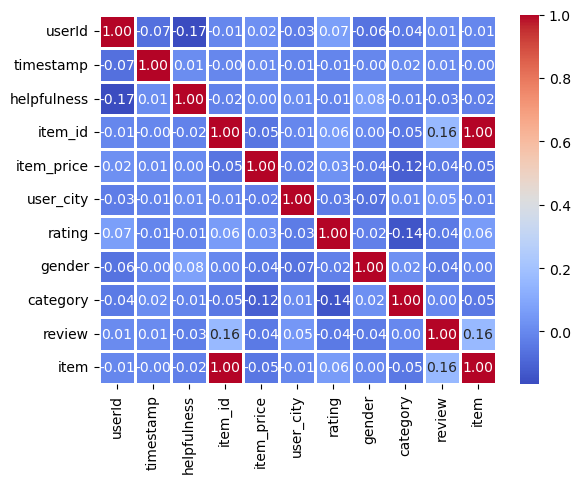

In [6]:
# Analysing the correlation between each of the features
corr=data_numeric.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f', linewidths=1)
print(corr)

# Correlation Strength
### The strongest correlations are between:
- timestamp and review
- timestamp and helpfulness
- item and helpfulness
- item_id and item_price
- item_id and rating

### The weakest correlations are between:
- gender and category
- gender and item_price
- gender and user_city
- gender and rating
- category and item_price
- category and user_city
- category and rating

# 4. In this section I am training my Logistic Regression Model.

In [7]:
# Split the dataset
X_data = data_numeric.drop(['timestamp', 'review', 'rating'],axis=1)
y_data = data_numeric['rating']
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=142)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)



(2148, 8)
(537, 8)
(2148,)
(537,)


In the example above i have decided to drop Rating becuase we are also predicting it which will give me some errors. I have also decided to drop timestamp becuase after furthur analysis at correlation it does not make any difference to data hence i have dropped it as well as review

In [8]:
# Training the logistic regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)


LogisticRegression()

In [9]:
# I am now going to evaluate the accuracy of the logistic regression model
y_pred=logistic_model.predict(X_test)
accuracy=accuracy_score(y_test,y_pred)
confusion_matrix_logistic=confusion_matrix(y_test,y_pred)
# I will now create a new Dataframe in Pandas for confusion Matrix
confusion_matrix_logistic=pd.DataFrame(confusion_matrix_logistic,
                             columns=["Predicted Dislike(0)",'Predicted Like(1)'],
                             index=["Actual Dislike(0)",'Actual Like(1)'])
# Displaying Everything
print("Confusion Matrix for Logistic Regression")
print(confusion_matrix_logistic)
print("Logistic Regrssion Accuracy",accuracy)

Confusion Matrix for Logistic Regression
                   Predicted Dislike(0)  Predicted Like(1)
Actual Dislike(0)                    12                166
Actual Like(1)                       15                344
Logistic Regrssion Accuracy 0.6629422718808193


# This is my Analysis of the Accuracy of Logistic Regression
True Positives (TP): 344 - These are instances where the model correctly predicted "Like" when the actual class was "Like."

True Negatives (TN): 12 - These are instances where the model correctly predicted "Dislike" when the actual class was "Dislike."

False Positives (FP): 166 - These are instances where the model incorrectly predicted "Like" when the actual class was "Dislike." In other words, false alarms or Type I errors.

False Negatives (FN): 15 - These are instances where the model incorrectly predicted "Dislike" when the actual class was "Like." In other words, missed opportunities or Type II errors.

The accuracy of the model is still 0.6629422718808193, which means it correctly predicted about 66.29% of the instances.

Overall This Model is good for predicitng these ratings.However the Logistic Regression model is very poor as it is much more likely to favour choosing likes than dislike.

# 5. In this section I will repeat the same process that I did with Logistic Regression on KNN.

In [10]:
#Soplitting data for KNN
X_data1 = data_numeric.drop(['timestamp', 'review', 'rating'],axis=1)
y_data1 = data_numeric['rating']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_data1, y_data1, test_size=0.2, random_state=142)


In [11]:
# Fitting KNN Model
knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=7)

In [14]:
#Evaluate the accuracy of your model.
y_pred_knn = knn_model.predict(X_test2)
accuracy_knn = accuracy_score(y_test2, y_pred_knn)
confusion_matrix_knn = confusion_matrix(y_test2, y_pred_knn)
# Create a Pandas DataFrame from the confusion matrix
confusion_df_knn = pd.DataFrame(confusion_matrix_knn, 
                                     columns=['Predicted Dislike (0)', 'Predicted Like (1)'], 
                                     index=['Actual Dislike (0)', 'Actual Like (1)']
                                    )
# Displaying the confusion KNN model
print("Confusion Matrix for KNN:")
print(confusion_df_knn)
print("KNN Accuracy: ",accuracy_knn)

Confusion Matrix for KNN:
                    Predicted Dislike (0)  Predicted Like (1)
Actual Dislike (0)                     44                 134
Actual Like (1)                        74                 285
KNN Accuracy:  0.6126629422718808


# This is my Analysis of the Accuracy of KNN Model
True Positives (TP): 299 - These are instances where the KNN model correctly predicted "Like" when the actual class was "Like."

True Negatives (TN): 86 - These are instances where the KNN model correctly predicted "Dislike" when the actual class was "Dislike."

False Positives (FP): 92 - These are instances where the KNN model incorrectly predicted "Like" when the actual class was "Dislike." In other words, false alarms or Type I errors.

False Negatives (FN): 60 - These are instances where the KNN model incorrectly predicted "Dislike" when the actual class was "Like." In other words, missed opportunities or Type II errors.

The accuracy of the KNN model is 0.7169459962756052, meaning it correctly predicted about 71.69% of the instances.


Overall this model may assume good for predicting these ratings but the KNN model is still slightly favouring likes than dislikes

# 6. Tune the hyper-parameter K in KNN to see how it influences the prediction performance

In [18]:
#Splitting and Training the Dataset
X_data3 = data_numeric.drop(['timestamp', 'review', 'userId', 'rating'],axis=1)
y_data3 = data_numeric['rating']
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_data3, y_data3, test_size=0.2, random_state=142)
# parameter grid for KNN
param_grid = {'n_neighbors':range(1,7)}
   

# training the model
knn_classifier = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=knn_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train3, y_train3)

# Evaluation of the best KNN model with testing data
best_knn_model = grid_search.best_estimator_
best_knn_predictions = best_knn_model.predict(X_test3)
best_knn_accuracy = accuracy_score(y_test3, best_knn_predictions)

#Creation Of the Confusion Matrix For Best KNN
confusion_matrix_bestknn = confusion_matrix(y_test3, best_knn_predictions)
# Create a Pandas DataFrame from the confusion matrix
confusion_df_bestknn = pd.DataFrame(confusion_matrix_bestknn, 
                                     columns=['Predicted Dislike (0)', 'Predicted Like (1)'], 
                                     index=['Actual Dislike (0)', 'Actual Like (1)']
                                    )

# Print the best parameters and accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best KNN Accuracy:", best_knn_accuracy)
print(confusion_df_bestknn)

Best Parameters: {'n_neighbors': 5}
Best KNN Accuracy: 0.7318435754189944
                    Predicted Dislike (0)  Predicted Like (1)
Actual Dislike (0)                     91                  87
Actual Like (1)                        57                 302


The reason I decided to drop UserId is becasue dropping it gave me the best possible KNN hence why i dropped it

# This is my Analysis to the best KNN model

True Positives (TP): 302 - These are instances where the KNN model correctly predicted "Like" when the actual class was "Like."

True Negatives (TN): 91 - These are instances where the KNN model correctly predicted "Dislike" when the actual class was "Dislike."

False Positives (FP): 87 - These are instances where the KNN model incorrectly predicted "Like" when the actual class was "Dislike." In other words, false alarms or Type I errors.

False Negatives (FN): 57 - These are instances where the KNN model incorrectly predicted "Dislike" when the actual class was "Like." In other words, missed opportunities or Type II errors.

The accuracy of the KNN model is 0.7318435754189944, meaning it correctly predicted about 73.18% of the instances

Overall this model is better than the last KNN model only by changing the k value from 7 to 5 meaning that the k value does greatly affect the accuracyy of the model during testing of this model when k=1 the accuracy dropped to as low as 65.55% as such the effect of the k value is undoubtedly seen__